##Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = Warning)

In [2]:
df_taxi=pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df_taxi=df_taxi.sort_index(axis=0)
print(df_taxi.index.is_monotonic)

True


In [4]:
df_taxi=df_taxi.resample('1H').sum()

# Анализ временного ряда

In [5]:
decomposed = seasonal_decompose(df_taxi)

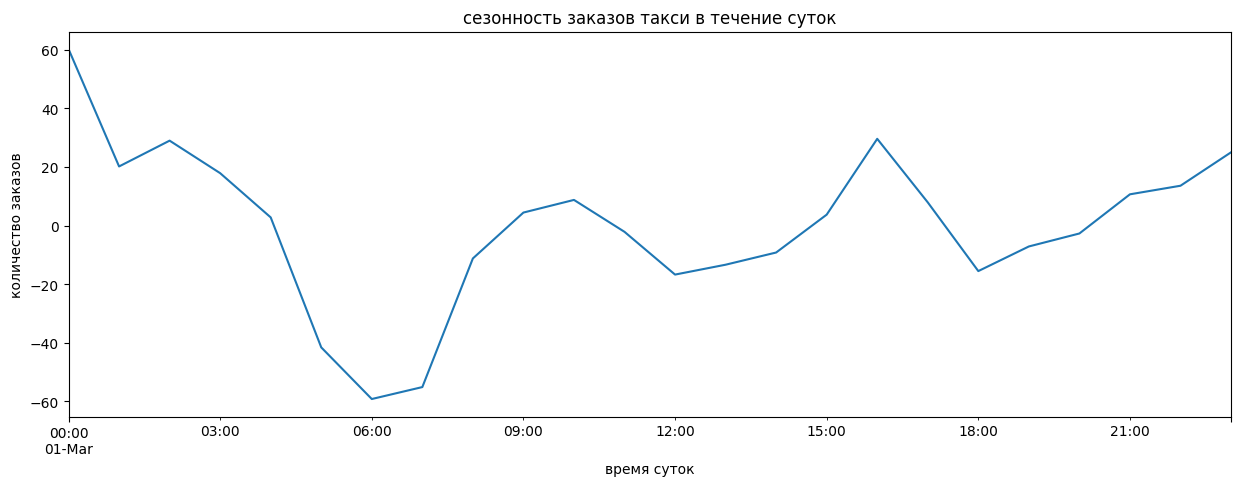

In [6]:
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(title='сезонность заказов такси в течение суток',
                                                    ylabel= 'количество заказов', xlabel= 'время суток', figsize=(15,5));

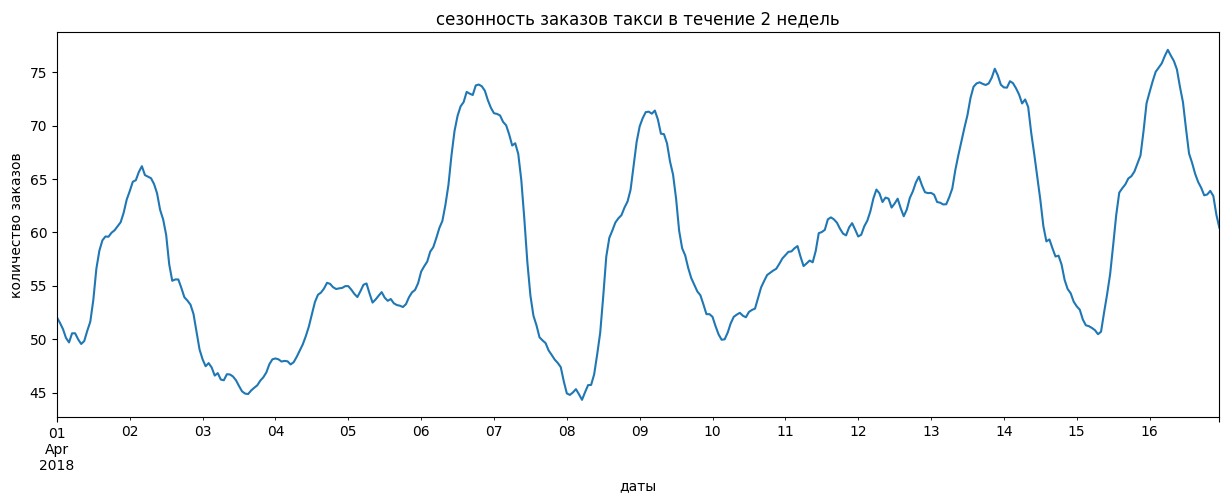

In [7]:
decomposed.trend['2018-04-01':'2018-04-16'].plot(title='сезонность заказов такси в течение 2 недель',
                                                 ylabel= 'количество заказов', xlabel= 'даты', figsize=(15,5));

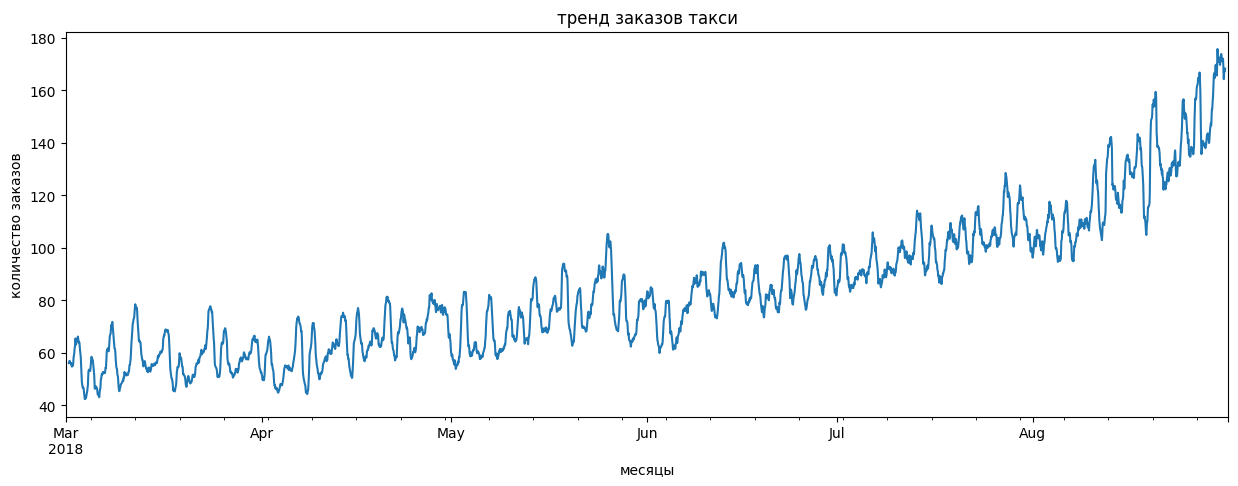

In [8]:
decomposed.trend.plot(title='тренд заказов такси',  ylabel= 'количество заказов', xlabel= 'месяцы', figsize=(15,5));

по графикам видно что минимальное количество заказов ранним утром, в течение утренних часов (6-11ч) количество заказов растет, в послеобеденные часы снижается, более высокий второй подъем к 17часам, затем спад и максимальный подъем в полночь. При оценке динамики по дням недели мы видим максимальные пики в субботу, снижение в воскресенье и вновь подъем в понедельник.


In [9]:
data1 = df_taxi['2018-04-01':'2018-04-08'].resample('1H').sum()
data1['rolling_mean']=data1.shift().rolling(24).mean()

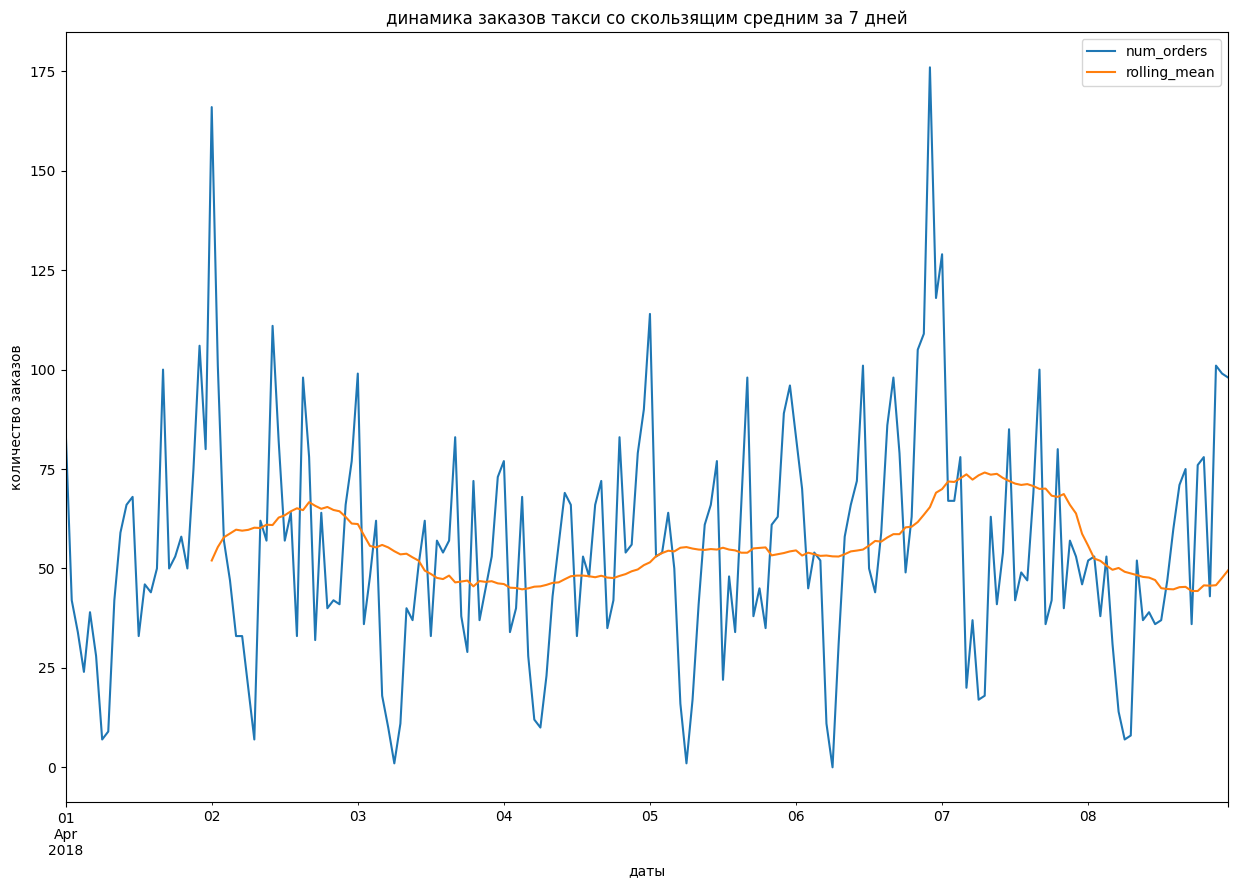

In [10]:
data1.plot(title='динамика заказов такси со скользящим средним за 7 дней', ylabel= 'количество заказов',
           xlabel= 'даты', figsize=(15,10));

 Как известно, в стационарном ряду скользящее среднее не должно иметь колебаний вокруг baseline, в нашем случае среднее количество заказов составляет около 50, имеются колебания от 30 до 75, следовательно строго стационарным ряд назвать нельзя.

Проверим временной ряд на стационарность с помощью теста Дики-Фуллера, для этого оценим значение p_value для проверки нулевой гипотезы о нестационарности временного ряда, альтернативная гипотеза говорит о том что ряд стационарен. С учетом нестабильности скользящего среднего в нашем ряду необходимо брать более строгий критерий p_value для оценки (0,01). Если его значение меньше 0,01, временной ряд стационарен, если нет, мы не можем принять гипотезу о стационарности временного ряда

In [11]:
adf_test=adfuller(df_taxi['num_orders'])

print('p_value = ' +str(adf_test[1]))

p_value = 0.028940051402613316


Критерий Дики-Фуллера не позволяет отвергнуть нулевую гипотезу о нестационарности ряда. Таким образом, графический анализ и статистический тест говорят о нестационарности ряда.

Оценив временные ряды заказов такси за сутки, неделю и 6 месяцев мы делаем выводы что:

1.в течение суток максимальное значение количество заказов в полночь, минимальное в 6 утра, умеренные подъемы к 11 и 17ч.

2.в течение недели имеют место колебания количества заказов с пиками по субботам и понедельникам

3.в течение периода март-сентябрь 2018г имеет место рост числа заказов, максимально выраженный в конце периода.

Оценим автокорреляцию нашего датасета

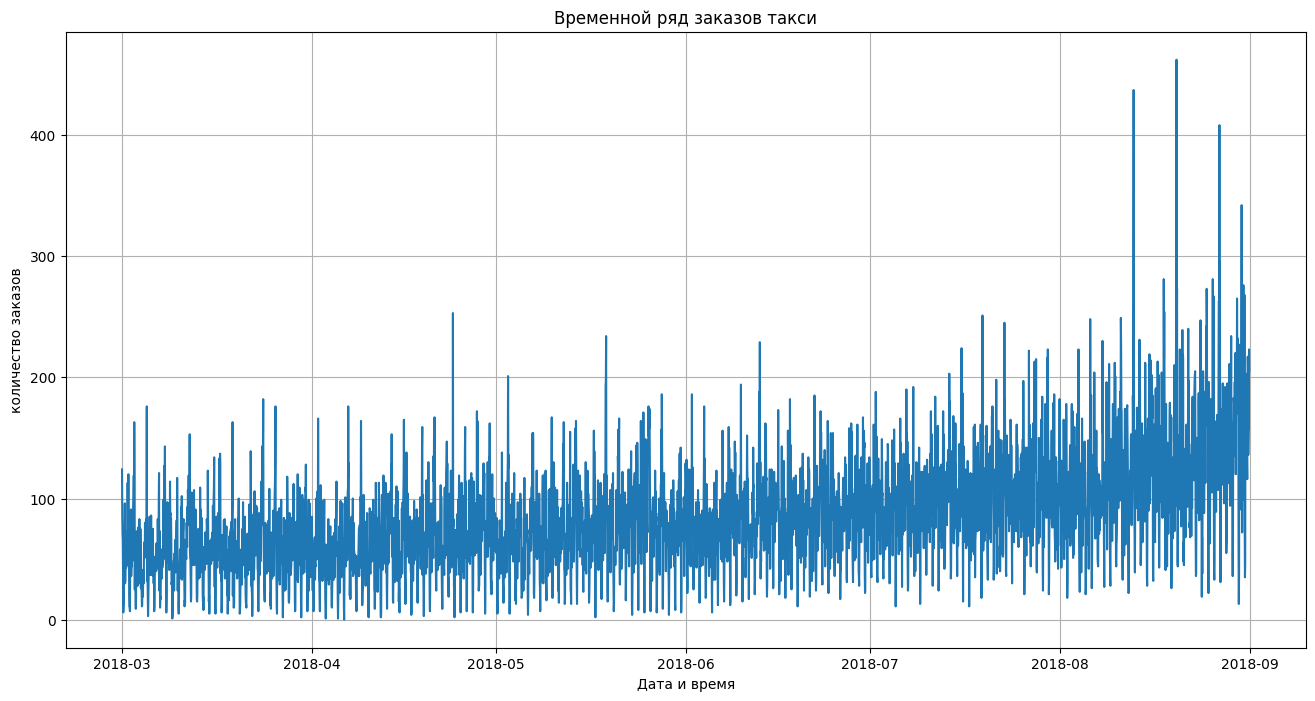

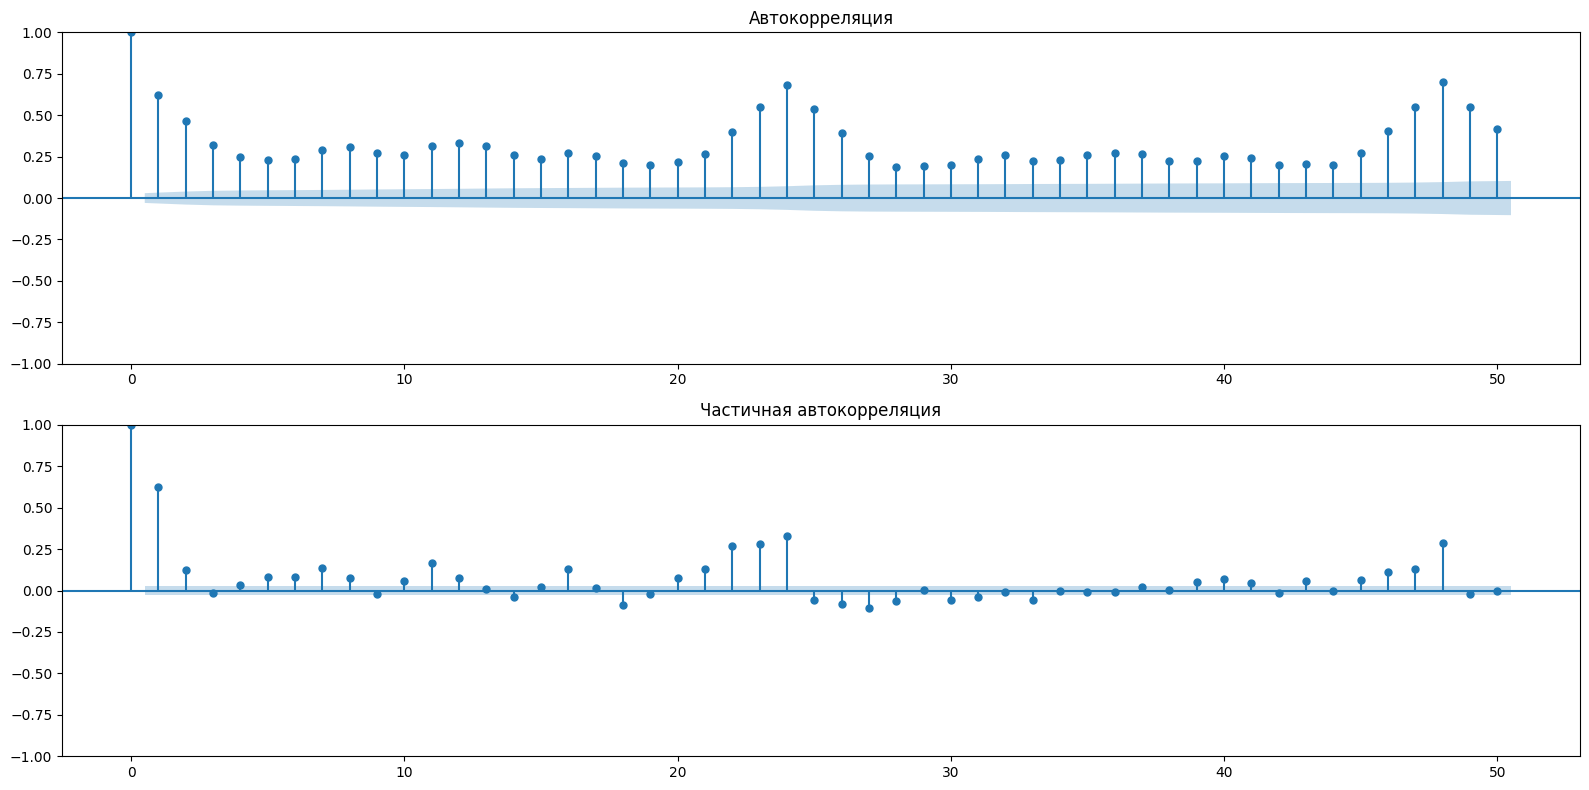

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(df_taxi.index, df_taxi['num_orders'])
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата и время')
plt.ylabel('количество заказов')
plt.grid(True)
plt.show()

# Рассчитываем автокорреляцию и частичную автокорреляцию
plt.figure(figsize=(16, 8))
plt.subplot(211)
plot_acf(df_taxi['num_orders'], lags=50, ax=plt.gca())
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(df_taxi['num_orders'], lags=50, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Наибольшая автокорреляция значений признака с ближайшими к пиковым часами и с лагом 24ч, т.е. суточным.

# Обучение моделей

Экспоненциальное сглаживание. В отличие от скользящего среднего в модели экспоненциального сглаживания (exponential smoothing) или экспоненциального скользящего среднего мы как  берем все предыдущие значения и  задаем каждому из наблюдений определенный вес и (экспоненциально) уменьшаем этот вес по мере углубления в прошлоеб при этом будущее прогнозное значение зависит как от текущего истинного, так и от текущего прогнозного значений. Важность этих значений определяется параметром альфа, задаваемым в диапазоне от 0 до 1 (чем
 больше, тем больший вес у истинного наблюдения).

In [13]:
alpha=0.7

exp_smoothing=[df_taxi['num_orders'][0]]

for i in range(1, len(df_taxi['num_orders'])):
  exp_smoothing.append(alpha*df_taxi['num_orders'][i]+(1-alpha)*exp_smoothing[i-1])


In [14]:

len(df_taxi), len(exp_smoothing)

(4416, 4416)

In [15]:
df_taxi['Exp_smoothing'] = exp_smoothing

In [16]:
last_hour = df_taxi.iloc[[-1]].index

In [17]:
last_hour = last_hour + timedelta(hours = 1)
last_hour

DatetimeIndex(['2018-09-01'], dtype='datetime64[ns]', name='datetime', freq='H')

In [18]:
df_taxi = pd.concat([df_taxi, pd.DataFrame(index = last_hour)])

In [19]:
df_taxi['Exp_smoothing'] = df_taxi['Exp_smoothing'].shift(1)

In [20]:
df_taxi.isna().sum()

num_orders       1
Exp_smoothing    1
dtype: int64

In [21]:
df_taxi.dropna()

,num_orders,Exp_smoothing
datetime,,
2018-03-01 01:00:00,85.0,124.000000
2018-03-01 02:00:00,71.0,96.700000
2018-03-01 03:00:00,66.0,78.710000
2018-03-01 04:00:00,43.0,69.813000
2018-03-01 05:00:00,6.0,51.043900
...,...,...
2018-08-31 19:00:00,136.0,206.217254
2018-08-31 20:00:00,154.0,157.065176
2018-08-31 21:00:00,159.0,154.919553


Методом экспоненциального сглаживания мы получили прогноз на 1 час вперед. Обучим также дерево решений и градиентный бустинг. Сначала добавим в датасет новые признаки и разделим датасет на тренировочную и тестовую выборку. гиперпараметры моделей подберем на кросс-валидации.

In [22]:
df_taxi1=df_taxi.copy()
df_taxi1
df_taxi1 = df_taxi1.dropna()

In [23]:
df_taxi1['dayofweek'] = df_taxi1.index.dayofweek

In [24]:
df_taxi1['day'] = df_taxi1.index.day

In [25]:
df_taxi1['hour'] = df_taxi1.index.hour

In [26]:
for lag in range(1,25):
        df_taxi1['lag_{}'.format(lag)] = df_taxi1['num_orders'].shift(lag)

In [27]:
df_taxi1['rolling_mean'] = df_taxi1['num_orders'].shift().rolling(24).mean()

In [28]:
train, test = train_test_split(df_taxi1, shuffle=False, test_size=0.1)
train = train.dropna()

X_train=train.drop('num_orders', axis=1)
y_train=train['num_orders']
X_test=test.drop('num_orders', axis=1)
y_test=test['num_orders']

In [29]:
model = DecisionTreeRegressor(random_state=42)

In [30]:
tscv=TimeSeriesSplit(n_splits=5)

In [31]:
param_grid = {
    'min_samples_leaf': range(7,14),
    'max_depth': range(7,14)
}

In [32]:
grid = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1

)
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(7, 14),
                         'min_samples_leaf': range(7, 14)},
             scoring='neg_root_mean_squared_error')

In [33]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика RMSE лучшей модели дерева решений на кросс-валидации:', grid.best_score_*-1)

Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=7, min_samples_leaf=10, random_state=42)
Метрика RMSE лучшей модели дерева решений на кросс-валидации: 29.25552551656515


In [42]:
pred=grid.best_estimator_.predict(X_test)
print("RMSE тестовой выборки дерева решений:", mean_squared_error(y_test, pred, squared=False))

RMSE тестовой выборки дерева решений: 53.10476899173492


In [43]:
model_1=LGBMRegressor(random_state=42)

In [36]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': range(3, 6)
}

In [37]:
grid_1 = GridSearchCV(
    model_1,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1

)
grid_1.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5123
[LightGBM] [Info] Number of data points in the train set: 3949, number of used features: 29
[LightGBM] [Info] Start training from score 78.418081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 6),
                         'n_estimators': [50, 100, 150]},
             scoring='neg_root_mean_squared_error')

In [38]:
print('Лучшая модель и её параметры:\n\n', grid_1.best_estimator_)
print ('Метрика RMSE лучшей модели градиентного бустинга на кросс-валидации:', grid_1.best_score_*-1)

Лучшая модель и её параметры:

 LGBMRegressor(max_depth=5, random_state=42)
Метрика RMSE лучшей модели градиентного бустинга на кросс-валидации: 24.71656930503222


In [39]:
X_test.dropna()
y_test.dropna()

datetime
2018-08-13 14:00:00    102.0
2018-08-13 15:00:00    175.0
2018-08-13 16:00:00    144.0
2018-08-13 17:00:00    152.0
2018-08-13 18:00:00    104.0
                       ...  
2018-08-31 19:00:00    136.0
2018-08-31 20:00:00    154.0
2018-08-31 21:00:00    159.0
2018-08-31 22:00:00    223.0
2018-08-31 23:00:00    205.0
Freq: H, Name: num_orders, Length: 442, dtype: float64

In [40]:
pred_1=grid_1.best_estimator_.predict(X_test)
print("RMSE тестовой выборки градиентного бустинга:", mean_squared_error(y_test, pred_1, squared=False))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE тестовой выборки градиентного бустинга: 40.87961099109875


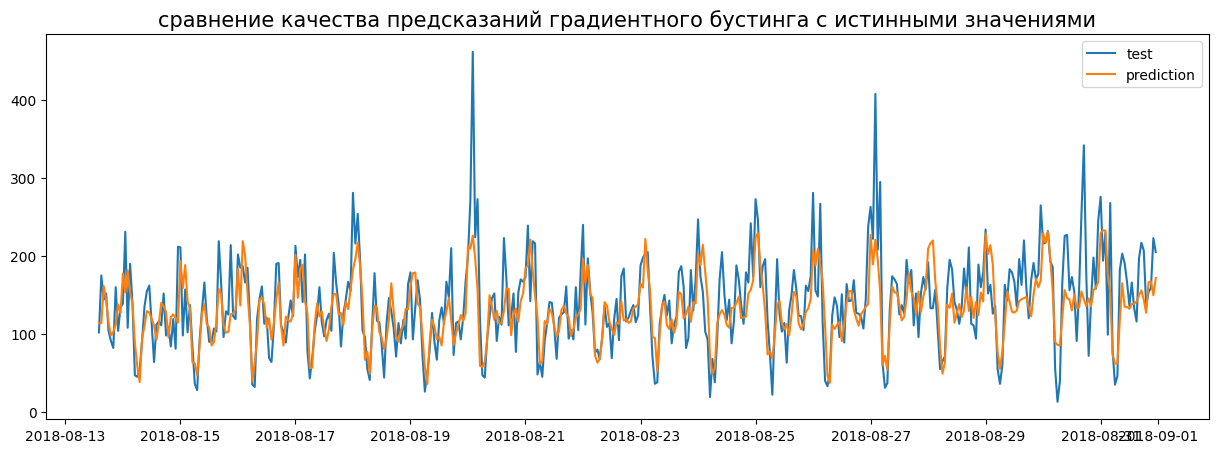

In [41]:
plt.figure(figsize=(15, 5))
plt.title("сравнение качества предсказаний градиентного бустинга с истинными значениями", fontsize=15)

plt.plot(y_test, label="test")
plt.plot(y_test.index, pred_1, label="prediction")
plt.legend()
plt.show()

Дерево решений дает несколько худшую в сравнении с градиентным бустингом с гиперпараметрами max_depth=4, n_estimators=150 метрику на кросс-валидации, поэтому лучшая модель - градиентный бустинг, соответственно данная модель применена для получения предсказаний на тестовой выборкеб результат градиентного бустинга на тестовой выборке но соответствует заданному критерию, соответственно заказчику в качестве модели для прогноза заказов будет предложена данная модель. Графическая оценка совпадения предсказаний с реальными значениями показала совпадение вполне достаточное, в прогнозе на 1 час модель может давать достаточно хороший по точности прогноз.

## ОБЩИЙ ВЫВОД:
проведен импорт библиотек и датасета, выполнено ресемплирование даннных по 1 часу. проведен анализ временного ряда, оценка на стационарность, построены графики сезонности и тренда.

Критерий Дики-Фуллера позволил отвергнуть нулевую гипотезу о нестационарности ряда, поэтому несмотря на графики тренда и сезонности можем с определенным допущением считать наш ряд стационарным

Оценив временные ряды заказов такси за сутки, неделю и 6 месяцев сделаны выводы:

1.в течение суток максимальное значение количество заказов в полночь, минимальное в 6 утра, умеренные подъемы к 11 и 17ч.

2.в течение недели имеют место колебания количества заказов с пиками по субботам и понедельникам

3.в течение периода март-сентябрь 2018г имеет место рост числа заказов, максимально выраженный в конце периода.
Получены предсказания количества заказов на каждый час методом экспоненциального среднего.

Следующим этапом в датасет добавлен ряд новых признаков, после разделения датасета на train/test из тренировочной выборки удалены пустые значения. Обучены 2 модели - дерево решений и LightGBM, для обеих моделей проведен подбор гиперпараметров на кросс-валидации.

Результаты обучения моделей: Лучшая модель и её параметры: LGBMRegressor(max_depth=4, n_estimators=150),

Метрика RMSE лучшей модели на кросс-валидации: 24.804610360100765,

RMSE тестовой выборки градиентного бустинга: 40.80576166792768